In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

from mwReconstruction.dataloader import destripeDataSet
from mwReconstruction.model import *

import numpy as np
import matplotlib.pyplot as plt
import random
import mrcfile
import pandas as pd
import torch
from torch.utils.data import Dataset
import os
from glob import glob
import scipy.io as io
# from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import normalized_mutual_information as nmi
from scipy import ndimage
from joblib import Parallel, delayed

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = os.path.join(PARENT_PATH, 'data/isoNet/')

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
cet_path = os.path.join(ISONET_PATH, 'RAW_dataset/RAW_allTomos_deconv/tomo10.mrc')    

my_dataset = destripeDataSet(path = cet_path, logTransform=False)
len(my_dataset)

928

In [3]:
input_2d_slice = my_dataset.x_data[len(my_dataset)//2][0].squeeze()
input_2d_slice.shape

fourier_2d_slice = fft.fftshift(fft.fft2(input_2d_slice))

m, n = fourier_2d_slice.size()

In [4]:
symmatrix = make_symmatrix(n, m)  # this is an np.array
symmask = torch.from_numpy(symmatrix).float()

symmask.shape, fourier_2d_slice.shape

(torch.Size([464, 928]), torch.Size([464, 928]))

(array([  2996.,  18962.,  92831., 132801.,  69284.,  39904.,  29644.,
         21592.,  15008.,   7570.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

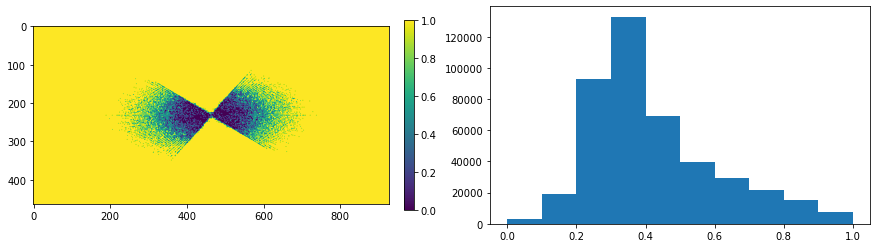

In [10]:
outlier_mask = my_dataset.x_data[len(my_dataset)//2][1].squeeze()
weight_matrix = my_dataset.x_data[len(my_dataset)//2][2].squeeze()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4))

plot0 = ax0.imshow(outlier_mask)
plt.colorbar(plot0, ax=ax0, fraction=0.025, pad=0.04)

ax1.hist(weight_matrix.flatten().numpy())

We want our neural network to do the following:

1. Embed Fourier space into a higher dimensional space with a non-linearity
2. Perform frequency based attention
3. Perform message passing:
    - Identity for non-MW coefficients
    - Sum of isotropic neighbors for MW coefficients
4. Embed back into Fourier space

Furthermore, we want to work only with the negative part of the spectrum since we want to avoid redundancy given by the fact that we are using real images.

In [11]:
outlier_mask_neg = torch.masked_select(outlier_mask, symmask == -1) # originally hier_mask_neg
weight_matrix_neg = torch.masked_select(weight_matrix, symmask == -1)
outlier_mask_neg.shape

torch.Size([215528])

In [12]:
_x_neg = fourier_2d_slice[symmask==-1].unsqueeze(1)
_x_neg.shape

torch.Size([215528, 1])

In [13]:
in_channels = 1
embedding_channels = 32
conv1 = ConvDic(in_channels, embedding_channels)
relu = nn.ReLU()
conv2 = ConvDic(embedding_channels, embedding_channels)
conv3 = ConvDic(embedding_channels, in_channels)

In [14]:
x_neg = conv1(_x_neg)
x_neg = relu(x_neg.real) + 1j * relu(x_neg.imag)
x_neg = conv2(x_neg)
# L_neg = att(Wh_neg=x_neg, N_neg=N_neg, k_neighbors=k_neighbors)
x_neg.shape

torch.Size([215528, 32])

In [15]:
(symmatrix == -1).astype(int)

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [32]:
# now we need to define the different behaviors for MW vs non-MW coefficients
aux_neg = make_N_neg_matrix(dr=3,
                            neg_mask=(symmatrix == -1).astype(int),
                            power_mask=outlier_mask.cpu().numpy(),
                        )
N_neg = torch.from_numpy(aux_neg.fillna(-1).to_numpy())
print(N_neg.shape)

torch.Size([215528, 65])


In [33]:
message_tensor = N_neg.long()
message_tensor = torch.cat((x_neg, torch.zeros(1, 32)))[message_tensor]

message_tensor.sum(1)

tensor([[ 0.5497-2.9784e-06j, -0.3308+4.4717e-06j, -0.1453+5.2126e-06j,
          ..., -0.2253-1.7881e-06j, -0.1466+3.5840e-06j,
         -3.0234-4.1998e-07j],
        [-1.8004+3.6756e-02j,  2.2878-1.8517e-02j,  2.0659-1.3286e-02j,
          ..., -0.7307+5.5235e-03j,  1.6647-3.4753e-02j,
         -0.3541-1.7597e-01j],
        [ 0.1753+2.0200e-01j, -0.1326-1.0176e-01j, -0.0945-7.3016e-02j,
          ..., -0.2965+3.0355e-02j,  0.1154-1.9099e-01j,
         -1.5267-9.6705e-01j],
        ...,
        [-1.1159-5.9883e-01j,  1.2092+8.9907e-01j,  0.8333+1.0480e+00j,
          ..., -0.3876-3.5951e-01j,  0.8949+7.2059e-01j,
         -0.3418-8.4442e-02j],
        [-0.3875-1.6981e+00j,  0.2672+2.5494e+00j,  0.0628+2.9718e+00j,
          ..., -0.3227-1.0194e+00j,  0.3098+2.0433e+00j,
         -0.6844-2.3945e-01j],
        [-1.2769-2.0755e+00j,  1.4593+3.1161e+00j,  1.1141+3.6324e+00j,
          ..., -0.4391-1.2460e+00j,  1.0631+2.4975e+00j,
         -0.3240-2.9267e-01j]], grad_fn=<SumBackward1>)

In [28]:
# from here we still need to set non-MW coefficients to the identity
message_tensor.sum(1).shape

torch.Size([215528, 32])

In [34]:
np.unique(symmask, return_counts=True)

(array([-1.,  0.,  1.], dtype=float32), array([215528,      1, 215063]))